# Akoya Academy Webinar: PhenoImager Analysis
This notebook contains the necessary libraries and steps to import the single cell data from QuPath into Python. The files exported from QuPath are stored under `data/` folder.
## Step-4: SpatialScore
Step-4 covers the SpatialScore computation. More information about this can be found in this paper: [Immune cell topography predicts response to PD-1 blockade in cutaneous T cell lymphoma
](https://www.nature.com/articles/s41467-021-26974-6). An R version of SpatialScore computation can be found here: [nolanlab/SpatialScore](https://github.com/nolanlab/SpatialScore).



### Import necessary libararies

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import io

# Load necessary libraries
import numpy as np

import anndata as ad
import pandas as pd
import scanpy as sc

import seaborn as sns; sns.set(color_codes=True)
import scipy as sp
import tqdm.notebook as tqdm
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

### SpatialScore function

In [4]:

def computeSpatialScore(subAD, p1,p2,p3):
    # given three labels compute spatial score
    # as distance between closest centroids of p1 and p2 and p1 and p3
    # for each cell in p2, compute the distance between the closet cell in p1 and p3

    centroidsP1 = subAD.obs[subAD.obs['phenotype']==p1][['spatial_X','spatial_Y']].values
    centroidsP3 = subAD.obs[subAD.obs['phenotype']==p3][['spatial_X','spatial_Y']].values
    # create a new DF for p2
    
    p2DF = pd.DataFrame(columns=['objID','distP1P2','distP2P3'])

    for ix,row in tqdm.tqdm(subAD.obs.loc[subAD.obs['phenotype']==p2].iterrows(), total=subAD.obs.loc[subAD.obs['phenotype']==p2].shape[0]):
        c = row[['spatial_X','spatial_Y']].values.astype(float)
        distP1P2 = sp.spatial.distance.cdist([c],centroidsP1).min()
        distP2P3 = sp.spatial.distance.cdist([c],centroidsP3).min()
        p2DF = p2DF.append({'objID': ix,'distP1P2':distP1P2,'distP2P3':distP2P3},ignore_index=True)
    p2DF['spatialScore'] = p2DF['distP1P2']/p2DF['distP2P3']
    return p2DF

In [5]:
# Read the data
newAD = ad.read_h5ad('data/adata_phenotypes.h5ad')

In [6]:
#compute spatial score for each sample

s1DF = computeSpatialScore(newAD[newAD.obs['ImageID']=='NSCLC_S1'],p1='Tumor',p2='CD8+ T cells',p3='Macrophages')
s2DF = computeSpatialScore(newAD[newAD.obs['ImageID']=='NSCLC_S2'],p1='Tumor',p2='CD8+ T cells',p3='Macrophages')

  0%|          | 0/10823 [00:00<?, ?it/s]

  0%|          | 0/9776 [00:00<?, ?it/s]

In [7]:
# Here, we know S1 is a responder and S2 is a non-responder based on sample information (not shown here)
s1DF['Outcome'] = 'Responder'
s2DF['Outcome'] = 'Non-Responder'

### Plot SpatialScore per cell

Text(0.5, 0, '')

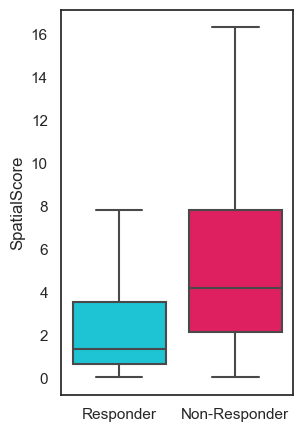

In [14]:
sns.set_style("white")

fig,ax=plt.subplots(1,1,figsize=(3,5))
sns.boxplot(data=pd.concat([s1DF,s2DF]),y='spatialScore', x='Outcome', showfliers=False, palette=['#00DBF2','#FF0055'], ax=ax)
ax.set_ylabel('SpatialScore')
ax.set_xlabel('')


### Plot spatial score per sample

Text(0.5, 0, '')

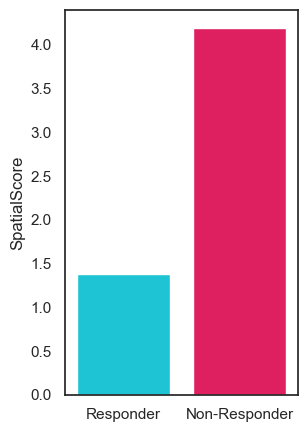

In [15]:
# for each sample, compute median spatial score
outDF = pd.concat([s1DF,s2DF]).groupby('Outcome').median()
outDF.reset_index(inplace=True)

# plot the median spatial score per sample
fig,ax=plt.subplots(1,1,figsize=(3,5))
sns.barplot(data=outDF, y='spatialScore', x='Outcome',order=['Responder','Non-Responder'], palette=['#00DBF2','#FF0055'], ax=ax)
ax.set_ylabel('SpatialScore')
ax.set_xlabel('')
